In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy.aamp)
"""
import pandas as pd
import ampiimts
import time

Best window sizes (hours): 24h, 15h, 48h


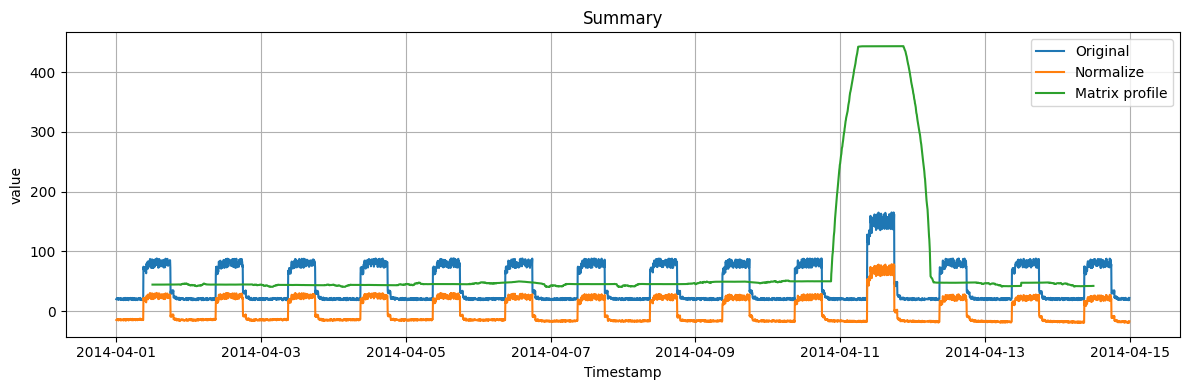

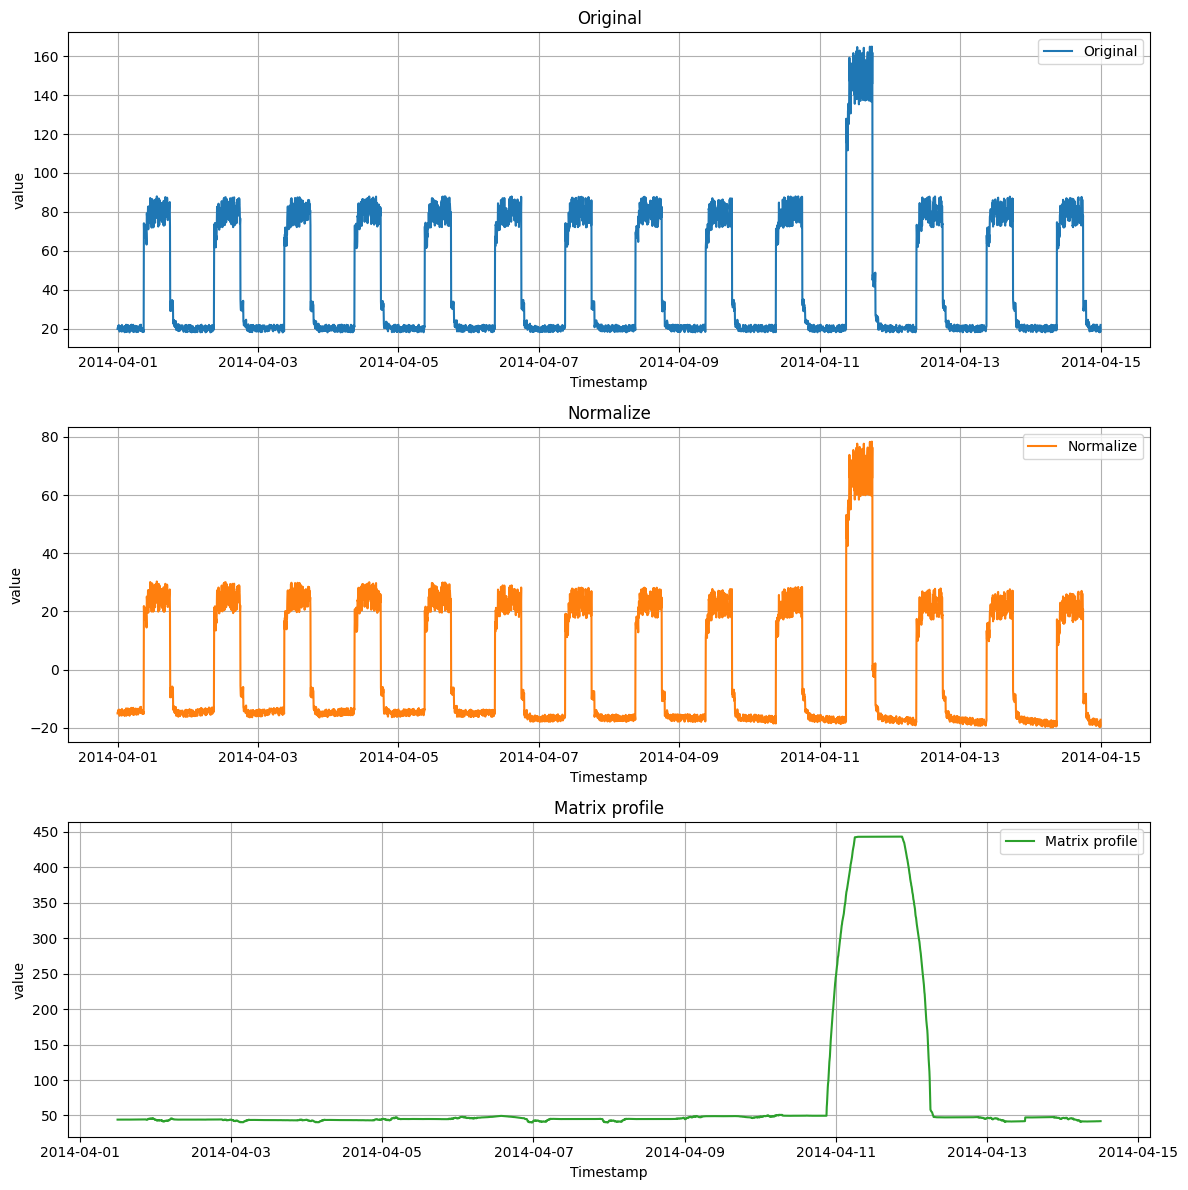

timing : 20.61215039000001


In [2]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/art_daily_jumpsup.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

Best window sizes (hours): 5h, 15h, 6h


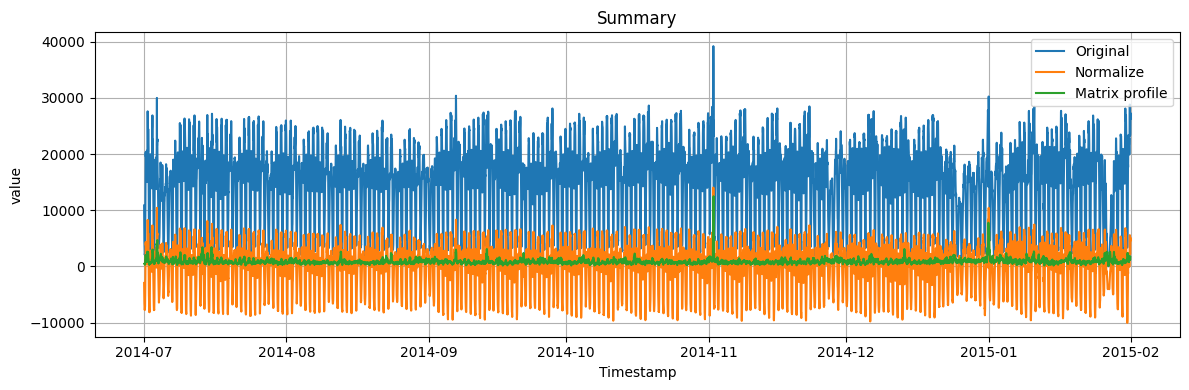

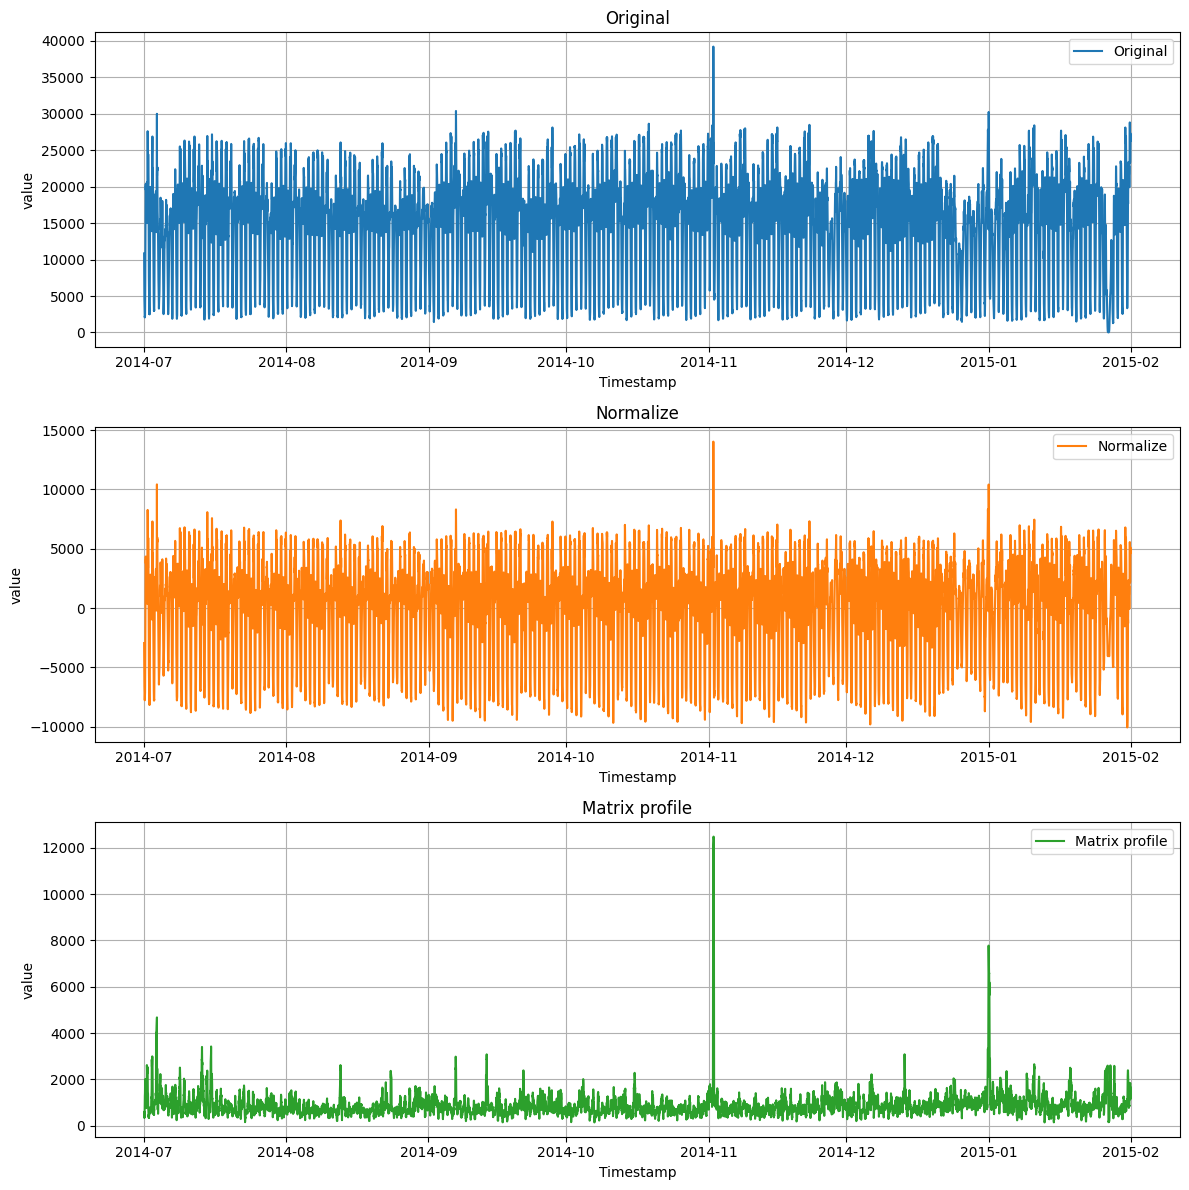

timing : 20.44488948700001


In [3]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/nyc_taxi.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

Best window sizes (hours): 1h, 2h, 3h


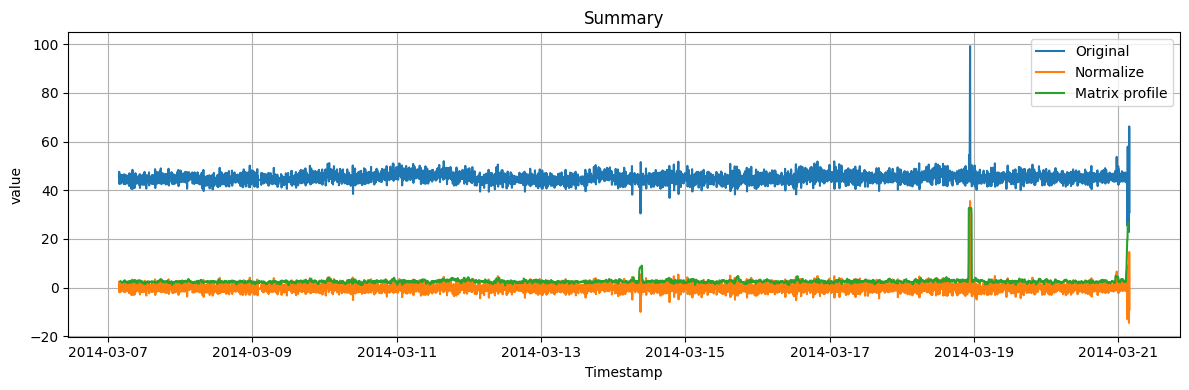

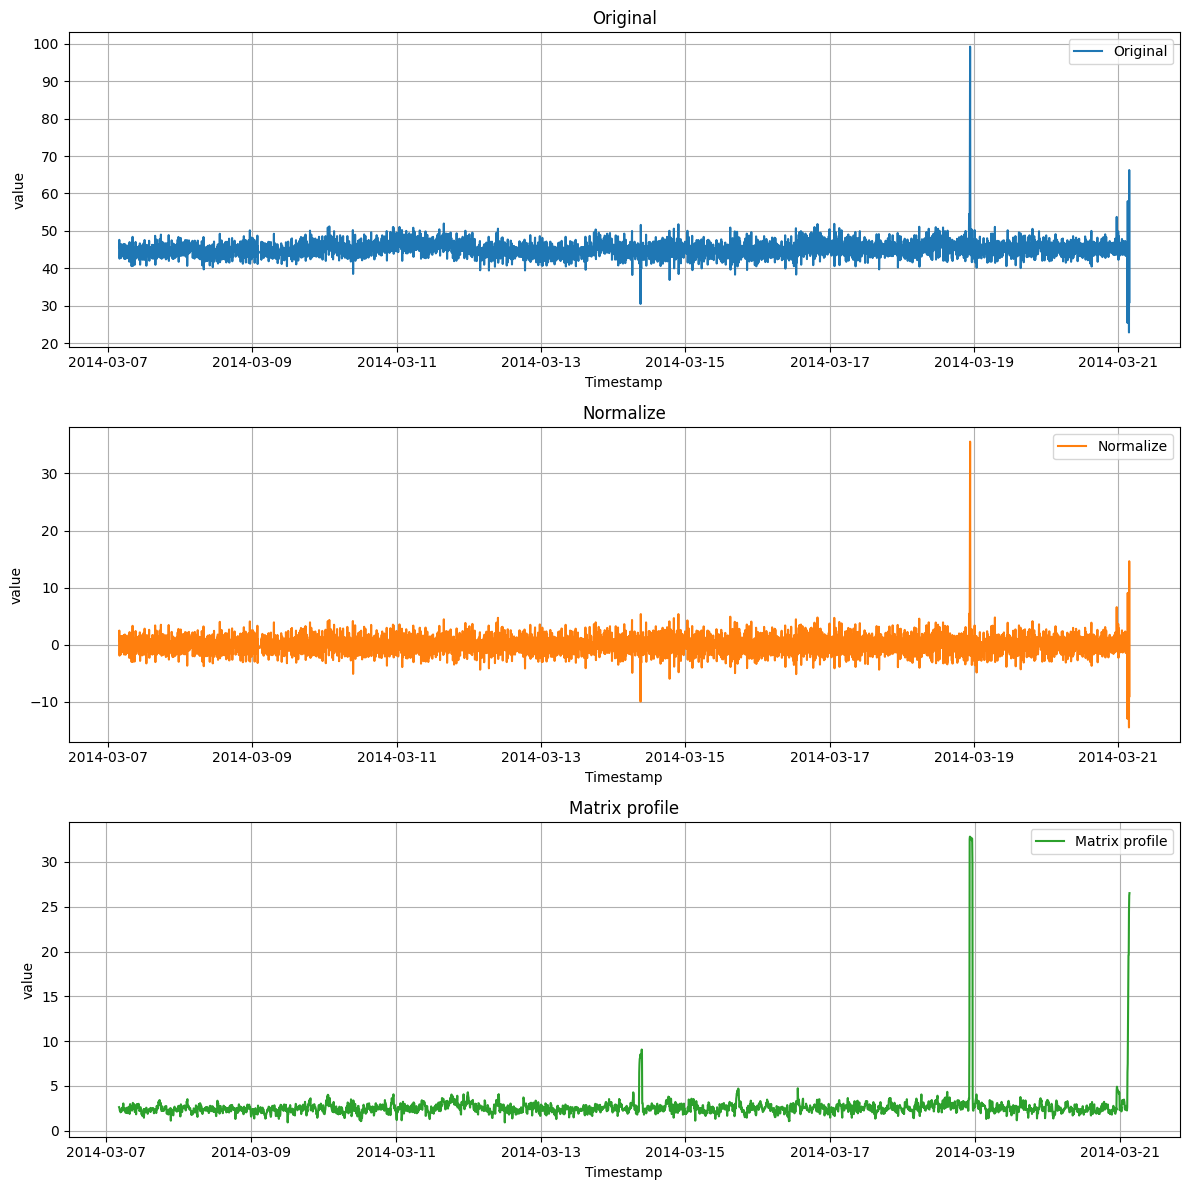

timing : 5.91432086399999


In [4]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/ec2_request_latency_system_failure.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

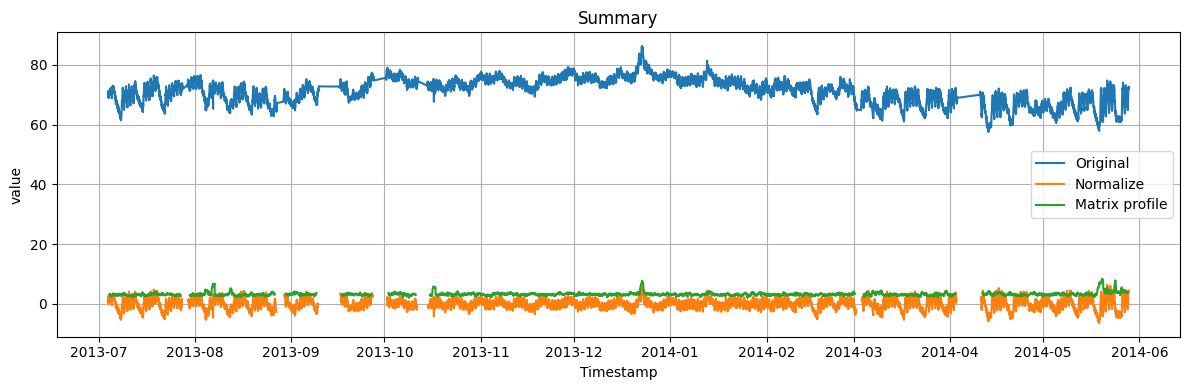

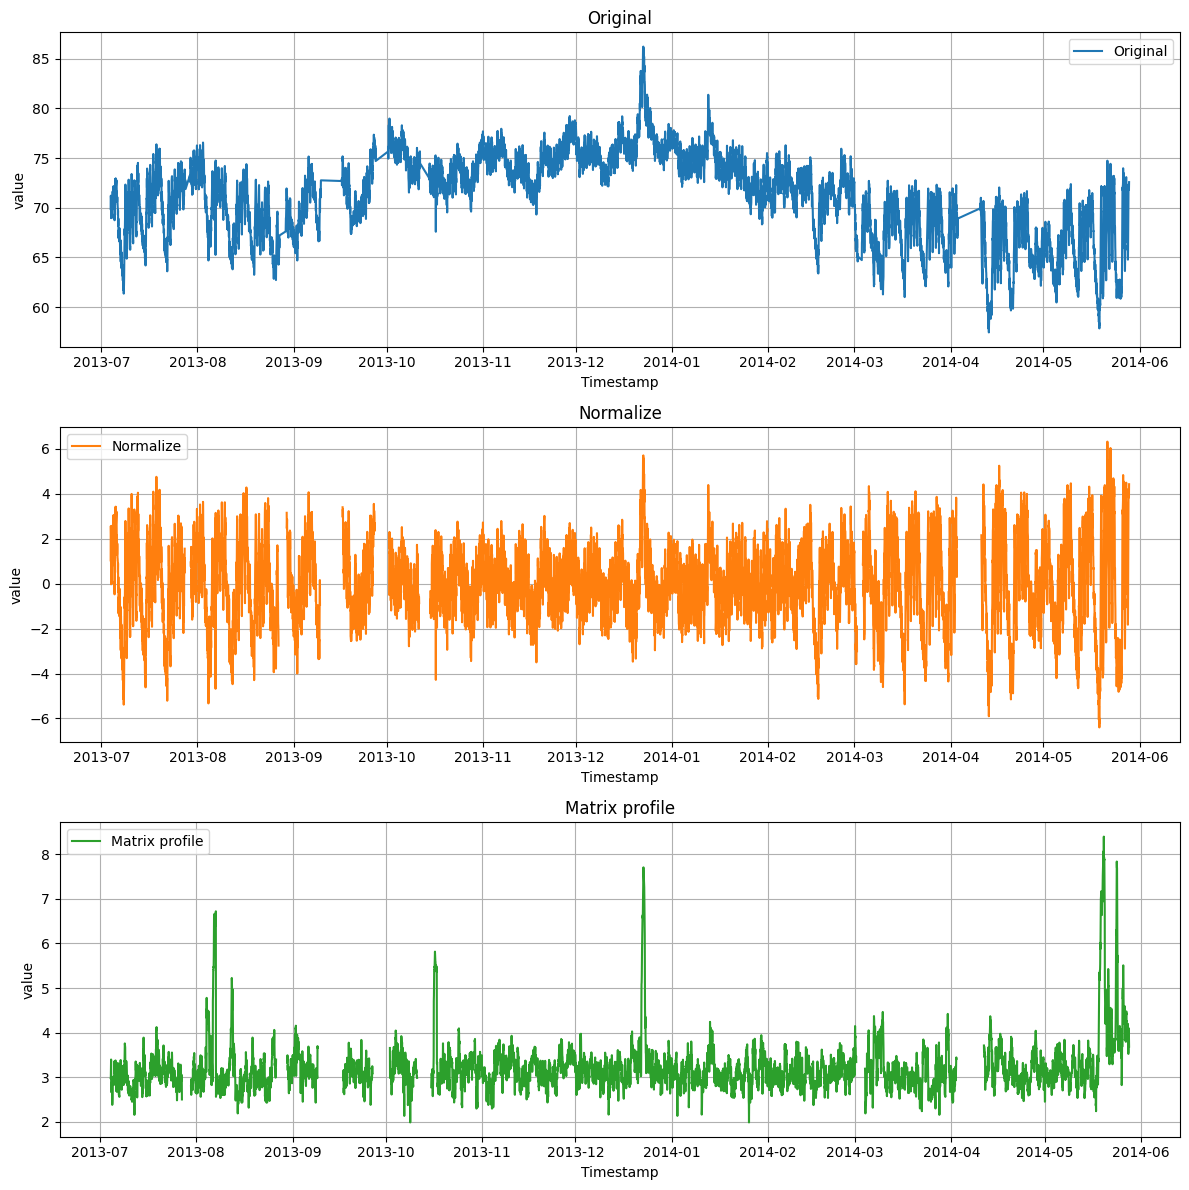

timing : 1.7251257070000179


In [5]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/ambient_temperature_system_failure.csv')
df_normalize = ampiimts.pre_processed(df, window_size='24h')
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

Best window sizes (hours): 1h, 2h, 3h


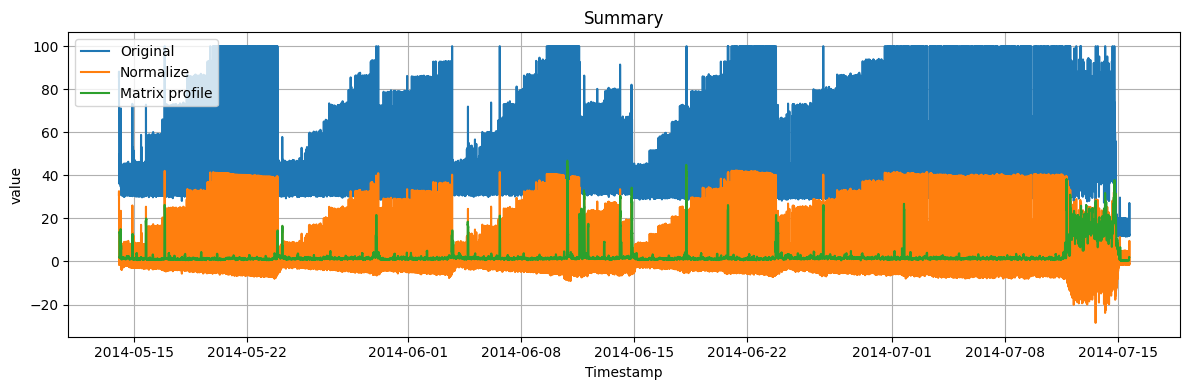

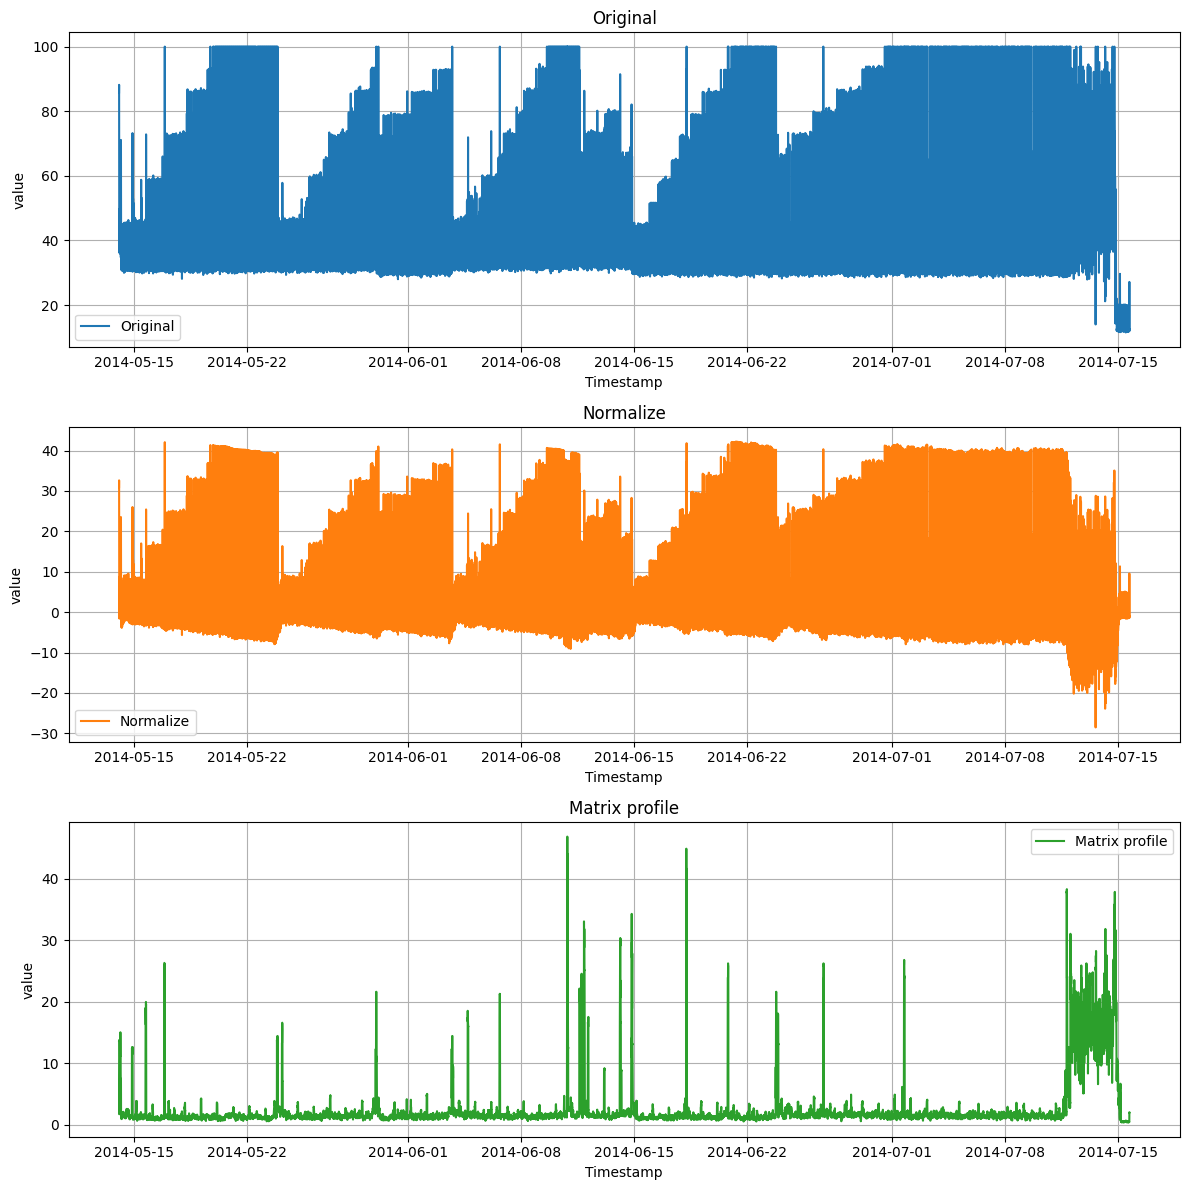

timing : 150.28936572000003


In [6]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/cpu_utilization_asg_misconfiguration.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

Best window sizes (hours): 1h, 2h, 3h


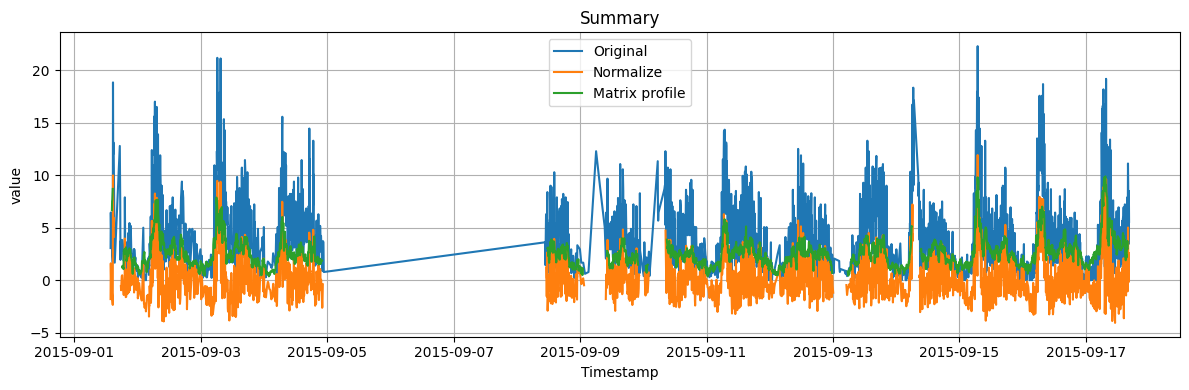

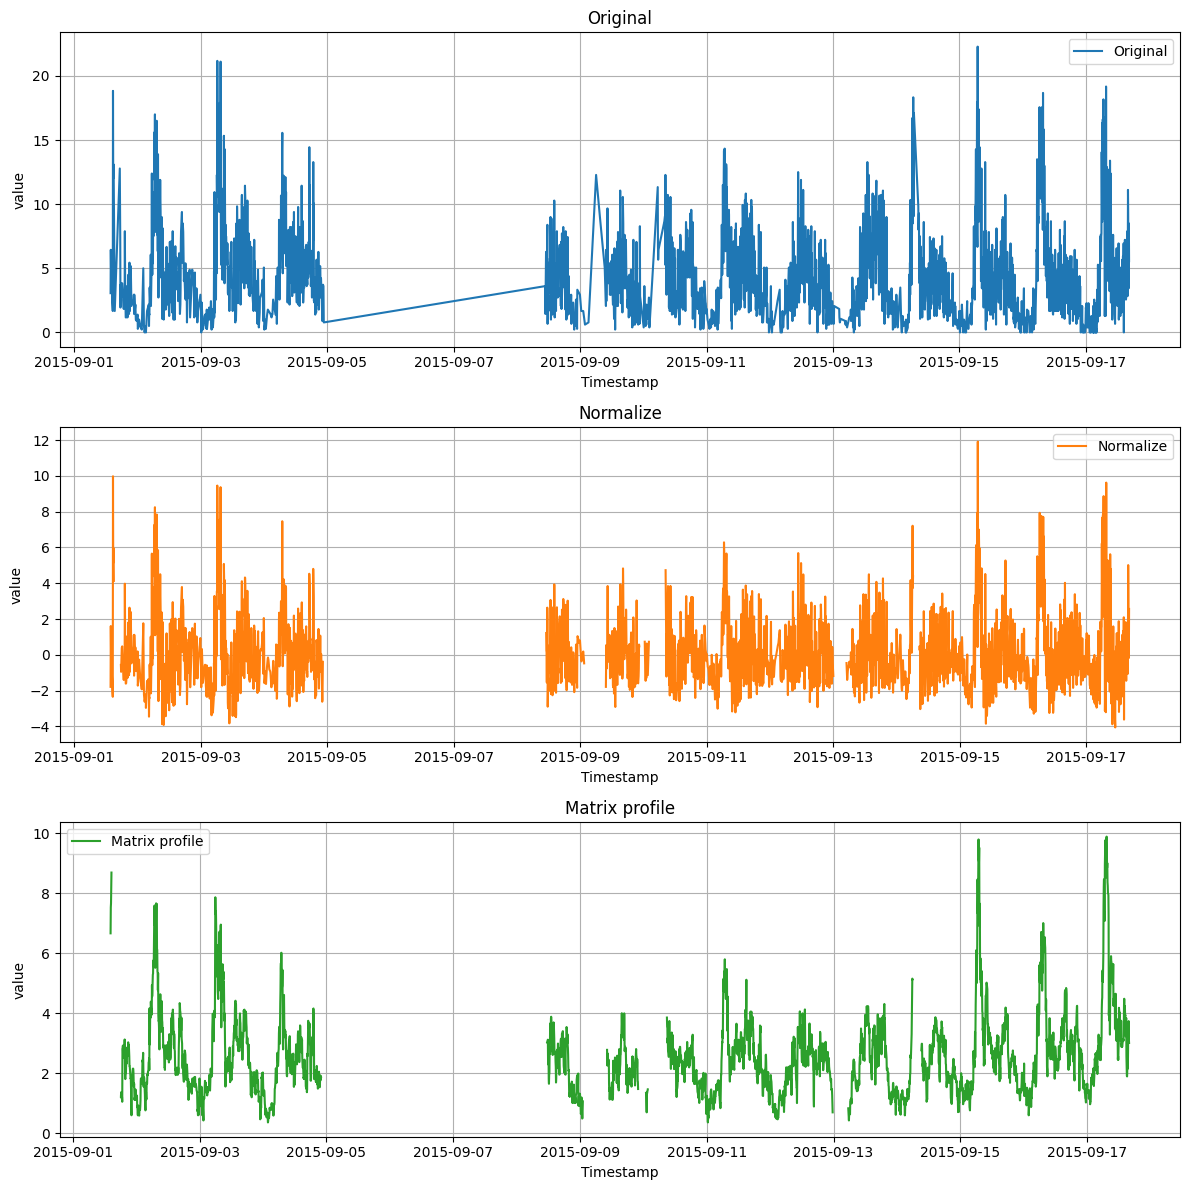

timing : 9.445336000999987


In [7]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/occupancy_6005.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")